In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-12-10 15:34:40.495019: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 15:34:40.831968: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 15:34:40.833971: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 15:34:42.323422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
# Define the Restricted Boltzmann Machine (RBM) class
class RBM:
    def __init__(self, visible_dim, hidden_dim):
        self.weights = tf.cast(tf.random.normal(shape=[visible_dim, hidden_dim], stddev=0.01), tf.float32)
        self.visible_bias = tf.cast(tf.zeros([visible_dim]), tf.float32)
        self.hidden_bias = tf.cast(tf.zeros([hidden_dim]), tf.float32)


    def sample_hidden(self, visible):
        visible = tf.cast(visible, tf.float32)  # Cast to float32
        hidden_activation = tf.matmul(visible, self.weights) + self.hidden_bias
        hidden_probs = tf.sigmoid(hidden_activation)
        return tf.nn.relu(tf.sign(hidden_probs - tf.random.uniform(tf.shape(hidden_probs))))

    def sample_visible(self, hidden):
        hidden = tf.cast(hidden, tf.float32)  # Cast to float32
        visible_activation = tf.matmul(hidden, tf.transpose(self.weights)) + self.visible_bias
        visible_probs = tf.sigmoid(visible_activation)
        return tf.nn.relu(tf.sign(visible_probs - tf.random.uniform(tf.shape(visible_probs))))


    def train(self, data, lr=0.01, epochs=10, batch_size=100):
        data = tf.cast(data, tf.float32)  # Ensure the data is of type float32
        
        for epoch in range(epochs):
            for i in range(0, data.shape[0], batch_size):
                batch = data[i:i+batch_size]
                v0 = batch
                h0 = self.sample_hidden(v0)
                v1 = self.sample_visible(h0)
                h1 = self.sample_hidden(v1)

                positive_grad = tf.matmul(tf.transpose(v0), h0)
                negative_grad = tf.matmul(tf.transpose(v1), h1)

                self.weights += lr * (positive_grad - negative_grad) / tf.cast(tf.shape(v0)[0], tf.float32)
                self.visible_bias += lr * tf.reduce_mean(v0 - v1, 0)
                self.hidden_bias += lr * tf.reduce_mean(h0 - h1, 0)

            error = tf.reduce_mean(tf.square(data - self.sample_visible(self.sample_hidden(data))))
            print(f'Epoch {epoch+1}, Reconstruction Error: {error.numpy()}')


In [10]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, _), _ = mnist.load_data()

# Normalize and flatten the images
train_images = train_images / 255.0
train_images = tf.reshape(train_images, [train_images.shape[0], -1])  # Flatten the images

# Create RBM instance
visible_dim = 784 # for MNIST 28x28 images
hidden_dim = 64   # number of hidden units
rbm = RBM(visible_dim, hidden_dim)

# Train the RBM
rbm.train(train_images, epochs=5)

Epoch 1, Reconstruction Error: 0.1494099199771881
Epoch 2, Reconstruction Error: 0.12294284999370575
Epoch 3, Reconstruction Error: 0.11259932816028595
Epoch 4, Reconstruction Error: 0.1065092384815216
Epoch 5, Reconstruction Error: 0.10161720961332321


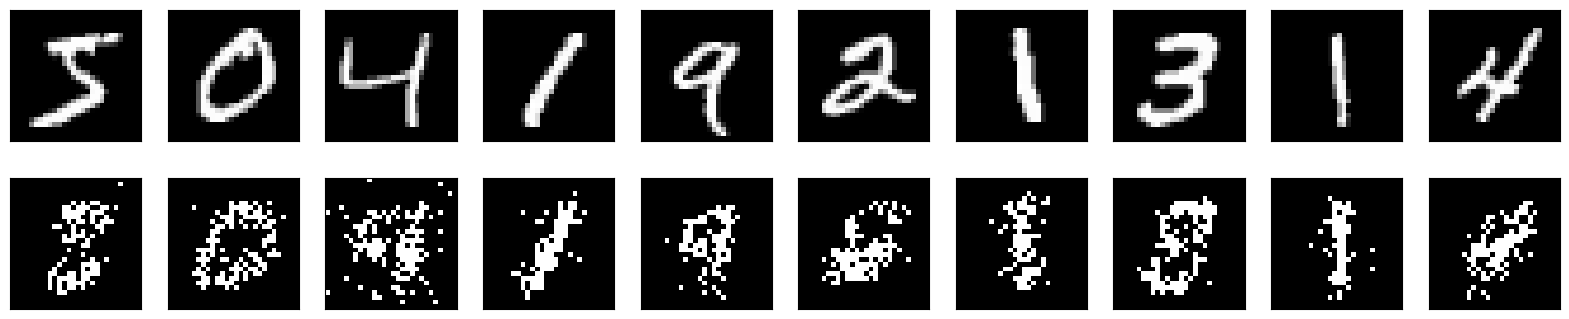

In [12]:
# Plotting original and reconstructed images
def plot_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original image
        ax = plt.subplot(2, n, i + 1)
        # Use tf.reshape to reshape the image for plotting
        original_image = tf.reshape(original[i], [28, 28])
        plt.imshow(original_image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed image
        ax = plt.subplot(2, n, i + 1 + n)
        # Use tf.reshape to reshape the image for plotting
        reconstructed_image = tf.reshape(reconstructed[i], [28, 28])
        plt.imshow(reconstructed_image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Select a subset of images to visualize original and reconstructed images
sample_images = train_images[:10]
sample_images_reconstructed = rbm.sample_visible(rbm.sample_hidden(sample_images))

plot_images(sample_images, sample_images_reconstructed)